In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
import time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,\
    precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import time
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
games = pd.read_csv('data/full_data.csv',index_col=0)

In [3]:
games['total_win'] = np.where(games['total_pts']>games['OverUnder'],1,0)

In [4]:
away_offense = ['QB1_away','RB1_away','RB2_away', 'WR1_away', 'WR2_away','WR3_away', 'WR4_away', 'TE1_away','TE2_away']
home_offense = ['QB1_home','RB1_home', 'RB2_home', 'WR1_home','WR2_home', 'WR3_home', 'WR4_home','TE1_home', 'TE2_home']
games['away_off_total'] = games.filter(away_offense).sum(axis = 1)
games['home_off_total'] = games.filter(away_offense).sum(axis = 1)
games['total_offense_sal'] = games['away_off_total'] + games['home_off_total']

In [5]:
games_2022 = games.loc[(games['season'] == 2022) & (games['Week'] != 13)]
games_dev = games.loc[games['season'] != 2022]
games_dev.dropna(subset=['QB1_home'], axis = 0, inplace = True)

C:\Users\binga\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [6]:
pred_cols = ['DST1_away', 'DST1_home', 'QB1_away', 'QB1_home', 'RB1_away',
       'RB1_home', 'RB2_away', 'RB2_home', 'WR1_away', 'WR1_home', 'WR2_away',
       'WR2_home', 'WR3_away', 'WR3_home', 'WR4_away', 'WR4_home', 'TE1_away',
       'TE1_home', 'TE2_away', 'TE2_home','away_off_total','home_off_total','total_offense_sal','PointSpread',
        'AwayTeamMoneyLine','HomeTeamMoneyLine','OverUnder']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(games_dev.filter(pred_cols).fillna(0),games_dev['total_win'], test_size=0.25, random_state=44)

In [8]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [9]:
random_state = 44

In [10]:
def plot_and_get_metrics(clf):
    preds_pp = cross_val_predict(clf, x_train, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

In [11]:
def plot_and_get_metrics_scaled(clf):
    preds_pp = cross_val_predict(clf, x_train_scaled, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

### KNN 

In [12]:
knn = KNeighborsClassifier()
start_time = time.time()
param_grid = {
    'n_neighbors' : [num for num in range(2,34)],
    'weights' : ['uniform','distance'],
    'p': [1,2],
    'n_jobs': [-1]
}

knn_grid = GridSearchCV(knn, param_grid, scoring='balanced_accuracy', n_jobs=-1)
knn_grid.fit(x_train, y_train)
best_knn = knn_grid.best_estimator_
print(time.time() - start_time)
best_knn

7.209737539291382


KNeighborsClassifier(n_jobs=-1, n_neighbors=30, weights='distance')

              precision    recall  f1-score   support

           0       0.51      0.55      0.53       589
           1       0.50      0.46      0.48       570

    accuracy                           0.51      1159
   macro avg       0.50      0.50      0.50      1159
weighted avg       0.51      0.51      0.50      1159



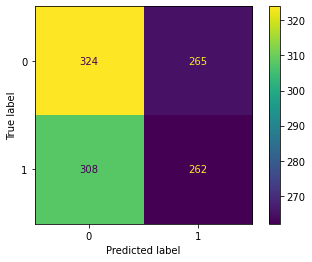

In [13]:
knn_run = KNeighborsClassifier(n_neighbors = 21, weights = 'distance')
best_knn = knn_run.fit(x_train,y_train)
knn_preds_pp, knn_preds, knn_cv_acc, knn_cv_prec, knn_cv_recall, knn_cv_auc = plot_and_get_metrics(best_knn)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.50      0.33      0.40       589
           1       0.49      0.66      0.56       570

    accuracy                           0.49      1159
   macro avg       0.50      0.50      0.48      1159
weighted avg       0.50      0.49      0.48      1159



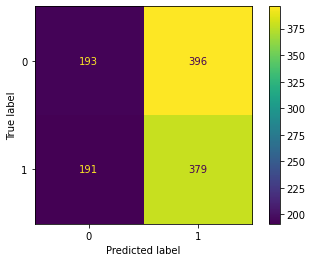

In [14]:
run_nb = GaussianNB()
run_nb.fit(x_train,y_train)
best_nb = run_nb
nb_preds_pp, nb_preds, nb_cv_acc, nb_cv_prec, nb_cv_recall, nb_cv_auc = plot_and_get_metrics(run_nb)

### SVM

In [15]:
svm = SVC(probability = True, random_state = random_state, max_iter = -1)
start_time = time.time()
param_grid = {
    'C' : [1,1.2,1.3,1.5,1.65,1.8,2],
    'kernel' : ['poly','rbf','linear'],
    'degree': [2,3],
}

svm_grid = GridSearchCV(svm, param_grid, scoring='balanced_accuracy', n_jobs=-1)
svm_grid.fit(x_train_scaled, y_train)
best_svm = svm_grid.best_estimator_
print(time.time() - start_time)
best_svm

21.252392053604126


SVC(C=1.5, degree=2, kernel='linear', probability=True, random_state=44)

              precision    recall  f1-score   support

           0       0.51      0.85      0.63       589
           1       0.47      0.14      0.21       570

    accuracy                           0.50      1159
   macro avg       0.49      0.49      0.42      1159
weighted avg       0.49      0.50      0.43      1159



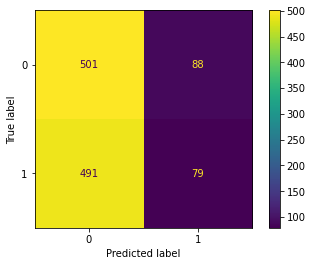

In [16]:
run_svm = SVC(C=1.5, kernel='poly', max_iter=50, probability=True, random_state=44)
svm_preds_pp, svm_preds, svm_cv_acc, svm_cv_prec, svm_cv_recall, svm_cv_auc = plot_and_get_metrics_scaled(best_svm)

### Random Forest

In [17]:
start_time = time.time()
rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
param_grid = {
    'n_estimators': [150,200,250],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [x for x in range(2,7)],
    'max_depth': [5,10,15,20],
    'bootstrap': [True]
}
rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', n_jobs=-1)
rf_clf.fit(x_train, y_train)
best_rf = rf_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_rf

1.64


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, n_estimators=200, random_state=44)

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       589
           1       0.52      0.52      0.52       570

    accuracy                           0.53      1159
   macro avg       0.53      0.53      0.53      1159
weighted avg       0.53      0.53      0.53      1159



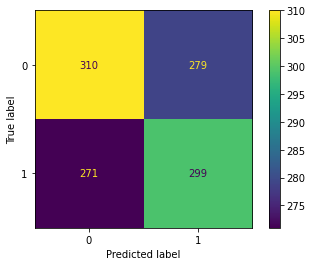

In [18]:
rf_run = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=6, n_estimators=250,
                       random_state=44)
rf_preds_pp, rf_preds, rf_cv_acc, rf_cv_prec, rf_cv_recall, rf_cv_auc = plot_and_get_metrics(best_rf)

### Light GBM

In [19]:
start_time = time.time()
lgbmc = lgb.LGBMClassifier(class_weight='balanced', random_state=random_state)

param_grid = {
    'max_depth': [5,10,15,20],
    # 'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01, 0.025],
    'n_estimators': [150, 200, 250],
    # 'feature_fraction': [0.5],
    'min_child_samples': [x for x in range(2,5)],
    'reg_alpha': [0.1, 0.5,1,1.5],
    'reg_lambda': [0.1, 0.5,1,1.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring='accuracy',
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

lgbmc_clf.fit(x_train, y_train)
best_lgb = lgbmc_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_lgb

11.69


LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=10,
               min_child_samples=2, n_estimators=150, random_state=44,
               reg_alpha=0.1, reg_lambda=0.1)

In [20]:
lgbm_run = lgb.LGBMClassifier(class_weight='balanced', learning_rate=0.025, max_depth=10,
               min_child_samples=2, n_estimators=200, random_state=44,
               reg_alpha=0.1, reg_lambda=0.5)
best_lgb = lgbm_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.52      0.51      0.52       589
           1       0.50      0.51      0.51       570

    accuracy                           0.51      1159
   macro avg       0.51      0.51      0.51      1159
weighted avg       0.51      0.51      0.51      1159



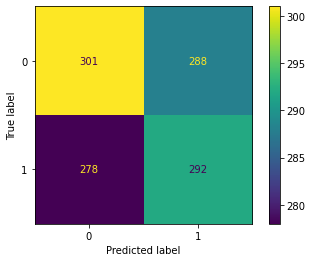

In [21]:
lgb_preds_pp, lgb_preds, lgb_cv_acc, lgb_cv_prec, lgb_cv_recall, lgb_cv_auc = plot_and_get_metrics(best_lgb)

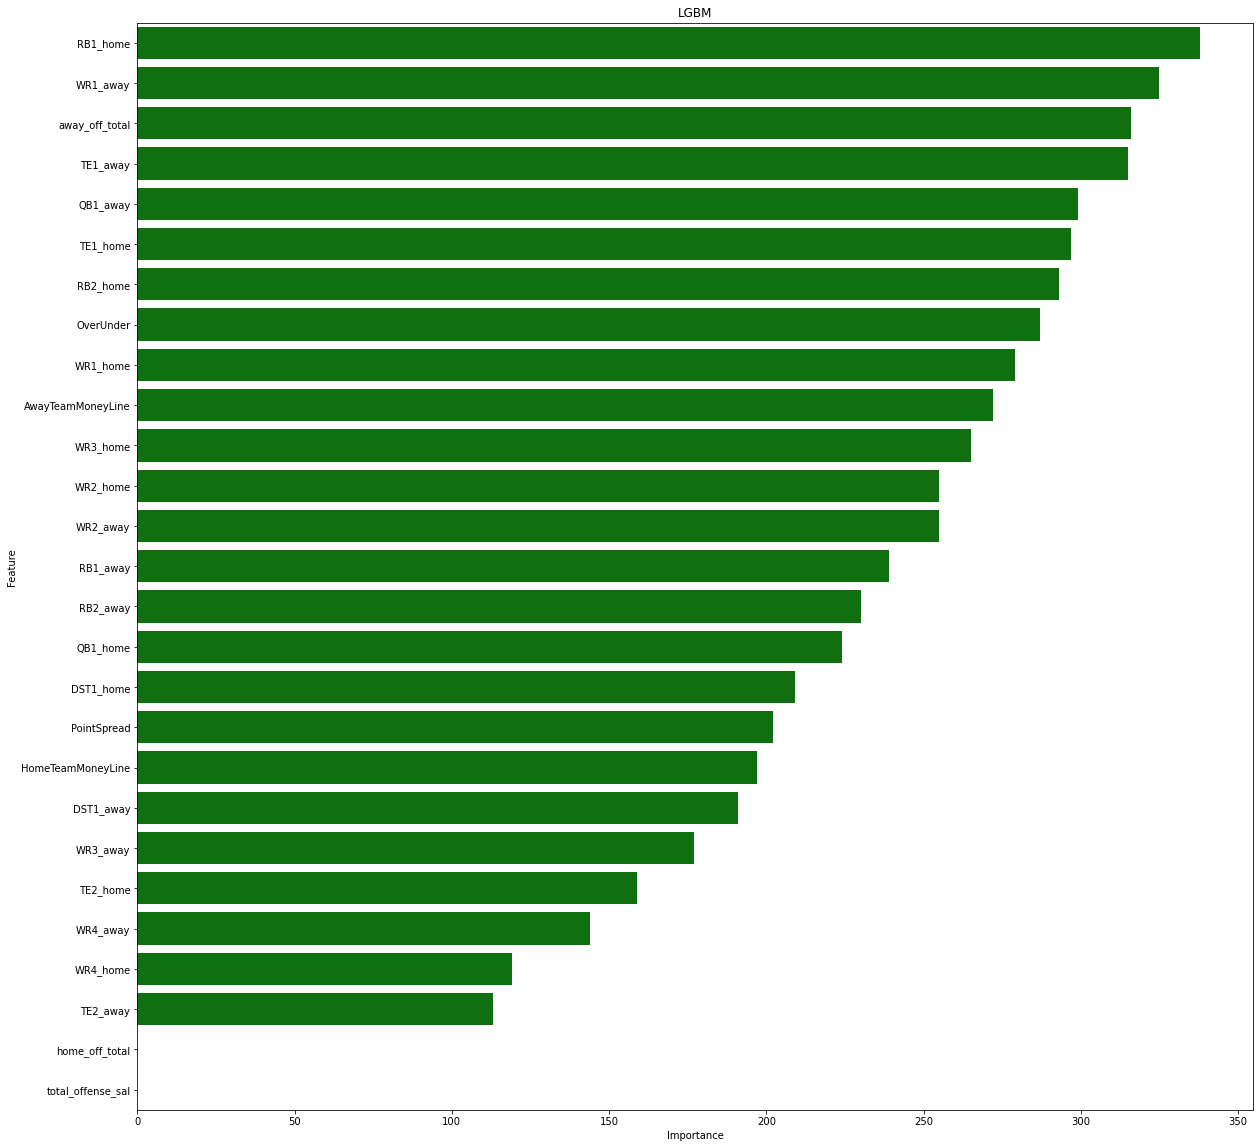

In [22]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_lgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('LGBM')
plt.savefig('feat_import_LGBM.png')

### XGBoost

In [23]:
import warnings
warnings.filterwarnings("ignore")
xgb = XGBClassifier(scale_pos_weight=4, random_state=random_state)
start_time = time.time()
param_grid = {
    'n_estimators': [150,250,300],
    'learning_rate': [0.05,0.1],
    'max_depth': [20,25],
    'subsample': [0.5, 0.75],
    'alpha': [0.1,1,1.5],
    'lambda': [0.5,1,5]
}


xgb_clf = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1)

xgb_clf.fit(x_train, y_train)
best_xgb = xgb_clf.best_estimator_
print((time.time() - start_time)/60)
best_xgb

[23:05:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9.392348690827687


XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=1, learning_rate=0.05,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=4,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [24]:
xgb_run = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='error', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=25,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=44, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)
best_xgb = xgb_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.52      0.25      0.34       589
           1       0.49      0.76      0.60       570

    accuracy                           0.50      1159
   macro avg       0.51      0.50      0.47      1159
weighted avg       0.51      0.50      0.47      1159



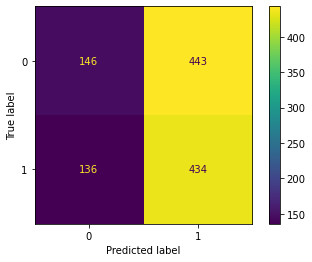

In [25]:
xgb_preds_pp, xgb_preds, xgb_cv_acc, xgb_cv_prec, xgb_cv_recall, xgb_cv_auc = plot_and_get_metrics(best_xgb)

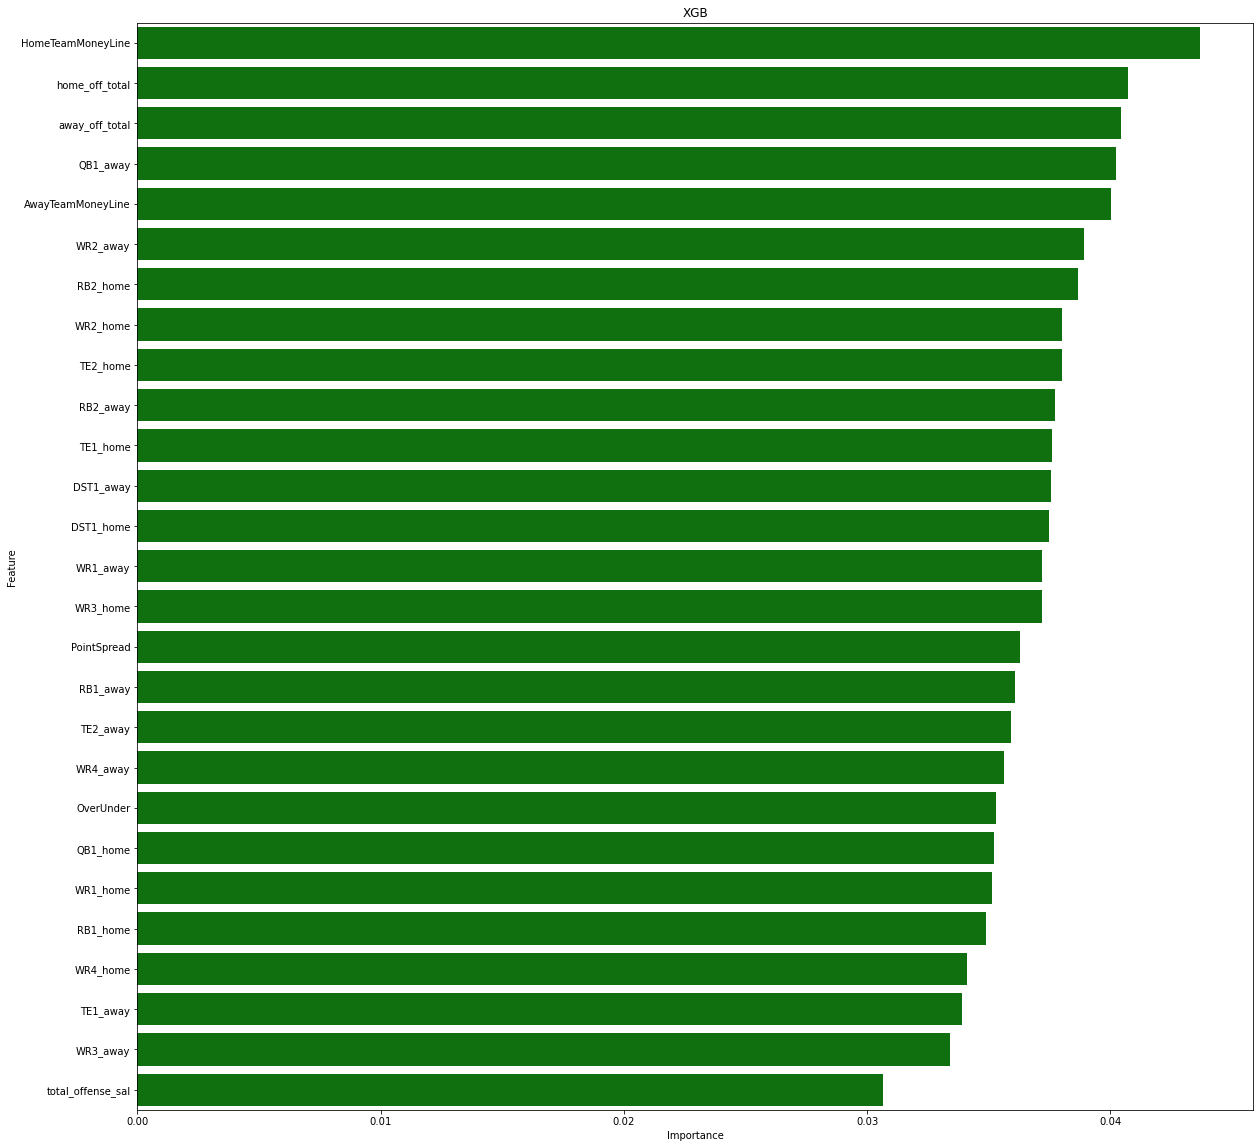

In [26]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_xgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('XGB')
plt.savefig('feat_import_xgb.png')

In [27]:
model_names = ['XGB', 'LGBM', 'RF',  'KNN', 'SVM','NB']
cv_accuracy = pd.Series([xgb_cv_acc, lgb_cv_acc, rf_cv_acc, knn_cv_acc, svm_cv_acc, nb_cv_acc], name='Accuracy')
cv_recall = pd.Series([xgb_cv_recall, lgb_cv_recall, rf_cv_recall, knn_cv_recall, svm_cv_recall, nb_cv_recall], name='Recall')
cv_precision = pd.Series([xgb_cv_prec, lgb_cv_prec, rf_cv_prec, knn_cv_prec, svm_cv_prec, nb_cv_prec],name='Precision')
cv_auc = pd.Series([xgb_cv_auc, lgb_cv_auc, rf_cv_auc,  knn_cv_auc, svm_cv_auc, nb_cv_auc], name='AUC')

In [28]:
scores_summary = pd.concat([cv_accuracy, cv_recall, cv_precision, cv_auc], axis=1)
scores_summary.columns = ['Accuracy', 'Recall', 'Precision', 'AUC']
scores_summary.index = model_names
scores_summary.style.highlight_max(color='green', axis=0)

,Accuracy,Recall,Precision,AUC
XGB,0.500431,0.761404,0.494869,0.504641
LGBM,0.511648,0.512281,0.503448,0.511658
RF,0.525453,0.524561,0.517301,0.525439
KNN,0.505608,0.459649,0.497154,0.504867
SVM,0.500431,0.138596,0.473054,0.494595
NB,0.493529,0.664912,0.489032,0.496293


In [29]:
comp_df = pd.DataFrame({'true': y_train, 'knn_preds_pp': knn_preds_pp, 'rf_preds_pp': rf_preds_pp,\
                        'lgb_preds_pp':lgb_preds_pp,'xgb_preds_pp':xgb_preds_pp ,'nb_preds_pp':nb_preds_pp,\
                        'svm_preds_pp': svm_preds_pp})
comp_df.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp
1524,0,0.574237,0.559987,0.682274,0.771202,0.635564,0.493167
218,1,0.459179,0.361550,0.302648,0.255885,0.006237,0.457371
1039,0,0.617017,0.453392,0.288789,0.666402,0.791332,0.517977
1229,0,0.652599,0.443908,0.203940,0.301594,0.738815,0.552466
61,1,0.586783,0.512780,0.739077,0.500567,0.723960,0.500000


Only bet when our model probability is higher than Vegas' implied probability. If both higher than Vegas, take the one with higher margin.

In [30]:
def under_return(df):
    if (df['bet_under'] and (df['true'] == 1)):
        return -100
    elif (df['bet_under'] & (df['true'] == 0)):
        #standard offer odds of -110 on the bet
        return round((100/-110)*-100,2)
    else: 
        return 0
    
def over_return(df):
    if (df['bet_over'] and (df['true'] == 0)):
        return -100
    elif (df['bet_over'] & (df['true'] == 1)):
        return round((100/-110)*-100,2)
    else: 
        return 0
def pred_vs_vegas(model_preds, comp, margin = 0):
    '''
    
    :param margin: margin between our predictions and vegas predictions to trigger making a bet (example: 0.05)
    :param comp: comparison dataframe to use for function (train or test predictions)
    :param model_preds: model column name of prediction probability
    :return:% return, $ risked, total $ returned
    '''
    #create working dataframe
    df_w = comp[['true',model_preds]]
    
    #calculate differential of our predictions vs standard -110 offer (translates to 52.38% probability)
    df_w['over_prob_adv'] = df_w[model_preds] - 0.5238
    df_w['under_prob_adv'] = (1-df_w[model_preds]) - 0.5238
    
    #flag whether the home differential is higher than the away differential
    df_w['over_adv_higher'] = df_w['over_prob_adv'] > df_w['under_prob_adv']
    
    #flag whether to bet on the home or away team
    df_w['bet_over'] = np.where((df_w['over_adv_higher'] & (df_w['over_prob_adv']>margin)), True, False)
    df_w['bet_under'] = np.where(((df_w['bet_over'] == False) & (df_w['under_prob_adv']>margin)), True, False)
    
    #generate bet returns
    df_w['over_risk'] = np.where(df_w['bet_over'], 100, 0)
    df_w['under_risk'] = np.where(df_w['bet_under'], 100, 0)
    df_w['under_return'] = df_w.apply(under_return, axis = 1)
    df_w['over_return'] = df_w.apply(over_return, axis = 1)
    
    #aggregate risks and returns
    df_w['risk'] = df_w['over_risk'] + df_w['under_risk']
    df_w['return'] = df_w['over_return'] + df_w['under_return']
    
    return df_w

def aggregate_returns(df_w):
    return df_w['risk'].sum(),df_w['return'].sum(),(df_w['return'].sum()/df_w['risk'].sum())

In [31]:
final_models = ['knn_preds_pp','svm_preds_pp','nb_preds_pp','rf_preds_pp','xgb_preds_pp','lgb_preds_pp']

In [32]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

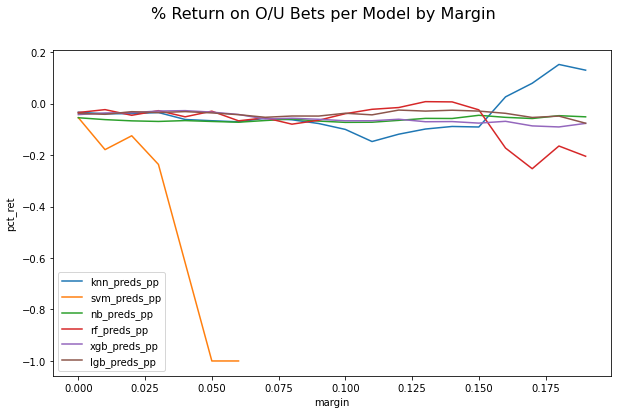

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df)
plt.suptitle('% Return on O/U Bets per Model by Margin', size=16)
plt.legend(loc='lower left')
plt.savefig('strat_3_ret.png')

In [44]:
higher_exp_val_df.loc[higher_exp_val_df['model'] == 'xgb_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
80,xgb_preds_pp,0.00,-0.042796,107900,-4617.69
81,xgb_preds_pp,0.01,-0.036376,105200,-3826.79
82,xgb_preds_pp,0.02,-0.035186,102300,-3599.53
83,xgb_preds_pp,0.03,-0.028942,98300,-2845.00
84,xgb_preds_pp,0.04,-0.027364,95000,-2599.56
85,xgb_preds_pp,0.05,-0.033080,92600,-3063.21
86,xgb_preds_pp,0.06,-0.042258,89700,-3790.50
87,xgb_preds_pp,0.07,-0.059796,86500,-5172.34
88,xgb_preds_pp,0.08,-0.056868,83600,-4754.17
89,xgb_preds_pp,0.09,-0.060942,80100,-4881.46


In [35]:
comp_df2 = pd.DataFrame({'true': games_2022['home_win'], 'knn_preds_pp': best_knn.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'rf_preds_pp': best_rf.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'lgb_preds_pp':best_lgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'xgb_preds_pp':best_xgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'nb_preds_pp':best_nb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'svm_preds_pp':best_svm.predict_proba(scaler.transform(games_2022.filter(pred_cols).fillna(0)))[:,1]})
comp_df2.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp
1552,0,0.561051,0.654624,0.582932,0.858019,0.592908,0.490725
1553,0,0.330413,0.350331,0.268958,0.281931,0.499178,0.494435
1554,0,0.467447,0.426394,0.213005,0.414488,0.701843,0.493939
1555,1,0.442951,0.445769,0.492713,0.618574,0.665853,0.494377
1556,0,0.532872,0.514398,0.575656,0.823464,0.689450,0.493043


In [36]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df2,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df2 = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

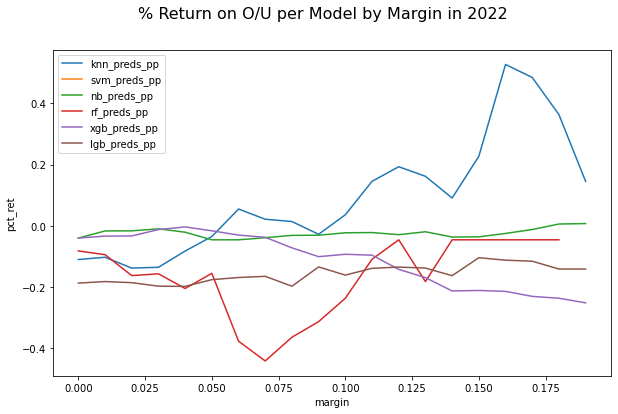

In [47]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df2)
plt.suptitle('% Return on O/U per Model by Margin in 2022', size=16)
plt.legend(loc='upper left')
plt.savefig('strat_3_ret.png')

In [48]:
higher_exp_val_df2.loc[higher_exp_val_df2['model'] == 'svm_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
20,svm_preds_pp,0.00,NaN,0,0.0
21,svm_preds_pp,0.01,NaN,0,0.0
22,svm_preds_pp,0.02,NaN,0,0.0
23,svm_preds_pp,0.03,NaN,0,0.0
24,svm_preds_pp,0.04,NaN,0,0.0
25,svm_preds_pp,0.05,NaN,0,0.0
26,svm_preds_pp,0.06,NaN,0,0.0
27,svm_preds_pp,0.07,NaN,0,0.0
28,svm_preds_pp,0.08,NaN,0,0.0
29,svm_preds_pp,0.09,NaN,0,0.0
